# Google traces


In [39]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os
from scipy.stats import gmean

In [40]:
datadir = '/home/aakahlow/GTraces/gem5/gtraces-results'

In [41]:
def getStat(filename, stat):
    #filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    #print(stat)
    #print(filename)
    try:
        with open(filename) as f:
            readlines = f.readlines()
            for l in readlines:
                if stat in l:
                    return l
            return 0.0 #for cases where stat was not found
    except: #for cases where the file was not found
        return 0.0

In [45]:
Stats = ['system.mem_ctrl.dram.avgRdBW', 'system.mem_ctrl.dram.avgWrBW', 'system.mem_ctrl.dram.busUtil', 
        'simSeconds', 'board.cache_hierarchy.ruby_system.l1_controllersX.L1Dcache.m_demand_misses', 
         'board.cache_hierarchy.ruby_system.l2_controllersX.L2cache.m_demand_misses']

# temporary 
#Stats = ['board.memory.mem_ctrl.dram.avgRdBW', 'board.memory.mem_ctrl.dram.avgWrBW', 
#         'board.memory.mem_ctrl.dram.busUtil', 'simSeconds', 
#         'board.cache_hierarchy.ruby_system.l1_controllersX.L1Dcache.m_demand_misses',
#         'board.cache_hierarchy.ruby_system.l2_controllersX.L2cache.m_demand_misses']

#modes = ['gem5', 'gem5_dcache', 'gem5_dcache_old', 'gem5_dcache_all_memory']
modes = ['1p', '2p', '4p', '8p', '16p', '32p']
devices = ['ddr4_2400', 'ddr5_8400', 'hbm_2000']
#inj_rate = ['20', '40', '60']
inj_rate = ['0']
pattern = ['charlie', 'delta', 'merced', 'whiskey']
#rd_prct = ['100', '70', '0']
rd_prct = ['0']
#duration = ['10ms']
duration = ['0']
configurations = ['baseline', 'fixed', 'aggressive', 'mesi2level-new']

In [46]:
#if pdf v1.5 is not used the hatches in generated figs do not show up on certain pdf viewers
# this function takes care of that issue
def savepdfviasvg(fig, name, **kwargs):
    import subprocess
    fig.savefig(name+".svg", format="svg", **kwargs)
    incmd = ["inkscape", name+".svg", "--export-pdf={}.pdf".format(name),
             "--export-pdf-version=1.5"] #"--export-ignore-filters",
    subprocess.check_output(incmd)

In [47]:
rows = []

for conf in configurations:
    for pat in pattern:
        for inj in inj_rate:
            for dev in devices:
                for rds in rd_prct:
                    for dur in duration:
                        for mod in modes:
                            stats = [conf, pat, inj, dev, rds, dur, mod]
                            for stat in Stats:
                                time_file_path = '{}-{}/{}/{}/{}/stats.txt'.format(datadir, conf, mod, dev, pat)
                                ret_line = getStat(time_file_path,stat)

                                tot_dcache_miss = 0
                                if stat == 'board.cache_hierarchy.ruby_system.l1_controllersX.L1Dcache.m_demand_misses':
                                    tot_dcache_miss = 0
                                    for cores in range(8):
                                        ret_line = getStat(time_file_path, stat.replace('X', str(cores)))
                                        if ret_line == 0.0:
                                            continue
                                        tot_dcache_miss = tot_dcache_miss + float(ret_line.split()[1])
                                    stat_val = tot_dcache_miss
                                elif stat == 'board.cache_hierarchy.ruby_system.l2_controllersX.L2cache.m_demand_misses':
                                    tot_l2cache_miss = 0
                                    for cores in range(8):
                                        ret_line = getStat(time_file_path,stat.replace('X',str(cores)))
                                        if ret_line == 0.0:
                                            continue
                                        tot_l2cache_miss = tot_l2cache_miss + float(ret_line.split()[1])

                                    stat_val = tot_l2cache_miss
                                else:
                                    stat_val = tot_dcache_miss
                                
                                if ret_line != 0:    
                                    if dev == 'hbm_2000':
                                        stat_val = ret_line.split()[1]
                                        ret_line = getStat(time_file_path,stat.replace('dram','dram_2'))
                                        stat_val = float(stat_val) + float(ret_line.split()[1])
                                    else:
                                        stat_val = ret_line.split()[1]
                                else:
                                    stat_val = 1
                                stats.append(stat_val)

                            rows.append(stats) 


df = pd.DataFrame(rows, columns=['conf', 'pattern','inj_rate','device','rd_perct','duration','mode',
                                 'readBW', 'writeBW', 'busUtil', 'simSeconds', 'l1dmiss','l2miss'])

In [48]:
df['totBW'] = df['readBW'].astype(float) + df['writeBW'].astype(float)

In [49]:
df['l1dmissperSec'] = (df['l1dmiss'].astype(float)/1000000) / df['simSeconds'].astype(float)
df['l2missperSec'] = (df['l2miss'].astype(float)/1000000) / df['simSeconds'].astype(float)

In [50]:
print(df['l1dmissperSec'])

0      0.000010
1      0.000010
2      0.000010
3      0.000010
4      0.000010
         ...   
283    0.000001
284    0.000001
285    0.000001
286    0.000001
287    0.000001
Name: l1dmissperSec, Length: 288, dtype: float64


In [51]:
#print(df[(df['pattern']=='charlie') & (df['device']=='ddr4_2400')])

In [52]:
def doplot_stat(mode, inj, duration, rd_pct, conf, stat):   
    i = 0
    
    for p, pat in enumerate(pattern):
        
        for dv, dev in enumerate(devices):
            
            d = df[(df['pattern']==pat) & (df['inj_rate']==inj) & (df['duration']==duration) & 
                  (df['mode']==mode) & (df['rd_perct']==rd_pct) & (df['device']==dev) & (df['conf']==conf)]
            
            
            if stat == 'readBW' or stat == 'writeBW' or stat == 'totBW':
                #print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0])/(1000), color='C'+str(dv), edgecolor='black')    
            else:
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(dv), edgecolor='black')
            
            i = i+1

        i = i+1
                    
    for i,pfrm in enumerate(['ddr4_2400', 'ddr5_8400', 'hbm_2000']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks([1,5,9,13], ['charlie', 'delta', 'merced', 'whiskey'], rotation=0, ha='center',fontsize=8)

In [12]:
def doplot_stat_ddr4(mode, inj, duration, rd_pct, conf, stat):   
    i = 0
    mean_list = []
    
    for p, pat in enumerate(pattern):
        
        for dv, dev in enumerate(['ddr4_2400']):
            
            d = df[(df['pattern']==pat) & (df['inj_rate']==inj) & (df['duration']==duration) & 
                  (df['mode']==mode) & (df['rd_perct']==rd_pct) & (df['device']==dev) & (df['conf']==conf)]
            
            
            if stat == 'readBW' or stat == 'writeBW' or stat == 'totBW':
                print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0])/(1000), color='C'+str(dv), edgecolor='black')
                mean_list.append(float(d[stat].iloc[0])/(1000))
            else:
                print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(dv), edgecolor='black')
                mean_list.append(float(d[stat].iloc[0]))
            
            i = i+1

        i = i+1
    
    plt.bar(i, gmean(mean_list), color='C'+str(dv), edgecolor='black')
    
    bench_2_use = ['charlie', 'delta', 'merced', 'whiskey']
    bench_2_use.append('gmean')
                    
    for i,pfrm in enumerate(['ddr4_2400']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks([0,2,4,6,8], bench_2_use, rotation=0, ha='center',fontsize=10)

In [61]:
def doplot_stat_ddr4_combined(mode, inj, duration, rd_pct, conf, stat, stat2):   
    i = 0
    mean_list = []
    mean_list2 = []
    
    for p, pat in enumerate(pattern):
        
        for dv, dev in enumerate(['ddr4_2400']):
            
            d = df[(df['pattern']==pat) & (df['inj_rate']==inj) & (df['duration']==duration) & 
                  (df['mode']==mode) & (df['rd_perct']==rd_pct) & (df['device']==dev) & (df['conf']==conf)]
            
            
            if stat == 'readBW' or stat == 'writeBW' or stat == 'totBW':
                print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0])/(1000), color='C'+str(dv), edgecolor='black')
                mean_list.append(float(d[stat].iloc[0])/(1000))
            else:
                print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(dv), edgecolor='black')
                mean_list.append(float(d[stat].iloc[0]))
                
                i = i+1
                
                print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat2].iloc[0]), color='C'+str(dv+1), edgecolor='black')
                mean_list2.append(float(d[stat2].iloc[0]))
            
            i = i+1

        i = i+1
    
    plt.bar(i, gmean(mean_list), color='C'+str(dv), edgecolor='black')
    plt.bar(i+1, gmean(mean_list2), color='C'+str(dv+1), edgecolor='black')
    
    bench_2_use = ['charlie', 'delta', 'merced', 'whiskey']
    bench_2_use.append('gmean')
                    
    for i,pfrm in enumerate(['L1', 'L2']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks([0.5,3.5,6.5,9.5,12.5], bench_2_use, rotation=90, ha='center',fontsize=14)

<IPython.core.display.Javascript object>


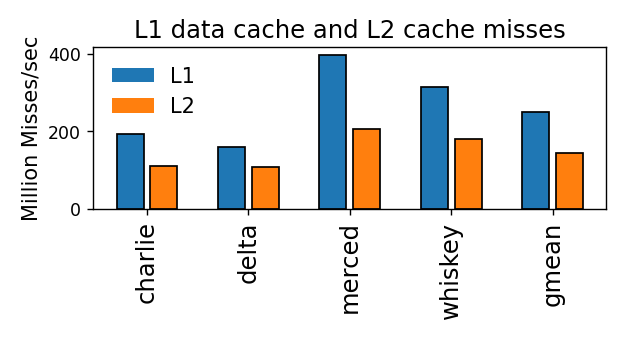

193.7958
193.7958
160.5901
160.5901
396.7929
396.7929
314.5871
314.5871


In [63]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 2.7

plt.figure()

doplot_stat_ddr4_combined('8p', '0', '0', '0', 'mesi2level-new', 'l1dmissperSec', 'l2missperSec')

plt.ylabel('Million Misses/sec', fontsize=12)
#lt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=1, prop={'size': 12}, frameon=0)
plt.title('L1 data cache and L2 cache misses', fontsize=14)
#plt.yscale("log")
plt.tight_layout()
plt.savefig('gtrace_mesi_combined_miss', format='pdf', dpi=1000)
savepdfviasvg(plt, "gtrace_mesi_combined_miss")

In [53]:
def doplot_curve(stat, bench, conf, norm=False):   
    i = 0
    
    ddr4 = []
    ddr5 = []
    hbm2 = []
    
    for j,dev in enumerate(devices):
        for m,mode in enumerate(modes):
            #print(bench)    
            d = df[(df['pattern']==bench) & (df['inj_rate']=='0') & (df['duration']=='0') & 
                  (df['mode']==mode) & (df['rd_perct']=='0') & (df['device']==dev) & (df['conf']==conf)]
            
            if dev == 'ddr4_2400':
                ddr4.append(float(d[stat].iloc[0])/(1000))
            elif dev == 'ddr5_8400':
                ddr5.append(float(d[stat].iloc[0])/(1000))
            elif dev == 'hbm_2000':
                hbm2.append(float(d[stat].iloc[0])/(1000))
               
    modes_plot = [m.replace("p", "") for m in modes]        
    
    plt.plot(modes_plot, ddr4, marker='x', color='C'+str(0), linewidth=1.3, markersize=3)
    plt.plot(modes_plot, ddr5, marker='o', color='C'+str(1), linewidth=1.3, markersize=3)
    plt.plot(modes_plot, hbm2, marker='s', color='C'+str(2), linewidth=1.3, markersize=3)
    
    for i,pfrm in enumerate(['ddr4', 'ddr5', 'hbm2']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    #plt.xticks((np.arange(len(bench_2_use))*3)+0.5, bench_2_use, rotation=80, ha='center',fontsize=11)

In [71]:
def plot_conf(conf, ylimit):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 4

    plt.figure()

    plt.subplot(2, 2, 1)
    doplot_curve('totBW', 'charlie', conf)
    plt.ylabel('BW (GB/s)', fontsize=13)
    plt.xlabel('Number of trace players', fontsize=13)
    plt.legend(loc='best', ncol=1, prop={'size': 11}, frameon=0)
    plt.title('charlie', fontsize=14)
    plt.ylim(ymax=ylimit)
    plt.tight_layout()

    plt.subplot(2, 2, 2)
    doplot_curve('totBW', 'delta', conf)
    plt.ylabel('BW (GB/s)', fontsize=13)
    plt.xlabel('Number of trace players', fontsize=13)
    plt.legend(loc='best', ncol=1, prop={'size': 11}, frameon=0)
    plt.title('delta', fontsize=14)
    plt.ylim(ymax=ylimit)
    plt.tight_layout()


    plt.subplot(2, 2, 3)
    doplot_curve('totBW', 'merced', conf)
    plt.ylabel('BW (GB/s)', fontsize=13)
    plt.xlabel('Number of trace players', fontsize=13)
    plt.legend(loc='best', ncol=1, prop={'size': 11}, frameon=0)
    plt.title('merced', fontsize=14)
    plt.ylim(ymax=ylimit)
    plt.tight_layout()

    plt.subplot(2, 2, 4)
    doplot_curve('totBW', 'whiskey', conf)
    plt.ylabel('BW (GB/s)', fontsize=13)
    plt.xlabel('Number of trace players', fontsize=13)
    plt.legend(loc='best', ncol=1, prop={'size': 11}, frameon=0)
    plt.title('whiskey', fontsize=14)
    plt.ylim(ymax=ylimit)
    plt.tight_layout()


<IPython.core.display.Javascript object>


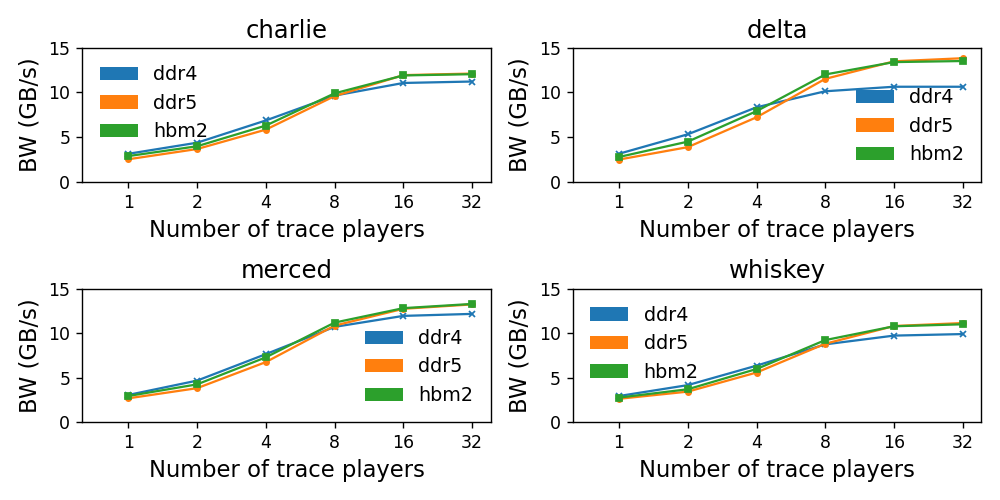

In [72]:
plot_conf('baseline', 15)

<IPython.core.display.Javascript object>


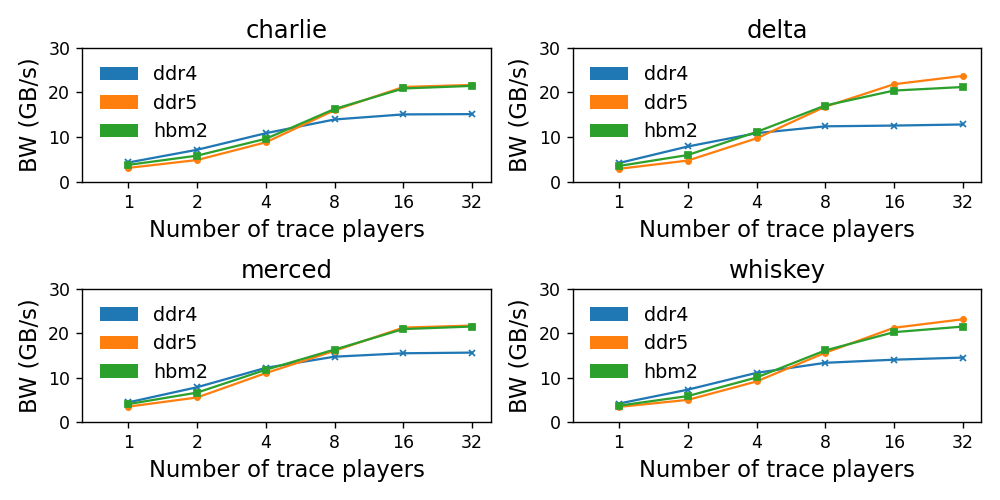

In [73]:
plot_conf('fixed', 30)
plt.savefig('gtrace_fixed_BW.png', format='png', dpi=150)
savepdfviasvg(plt, "gtrace_fixed_BW")

<IPython.core.display.Javascript object>


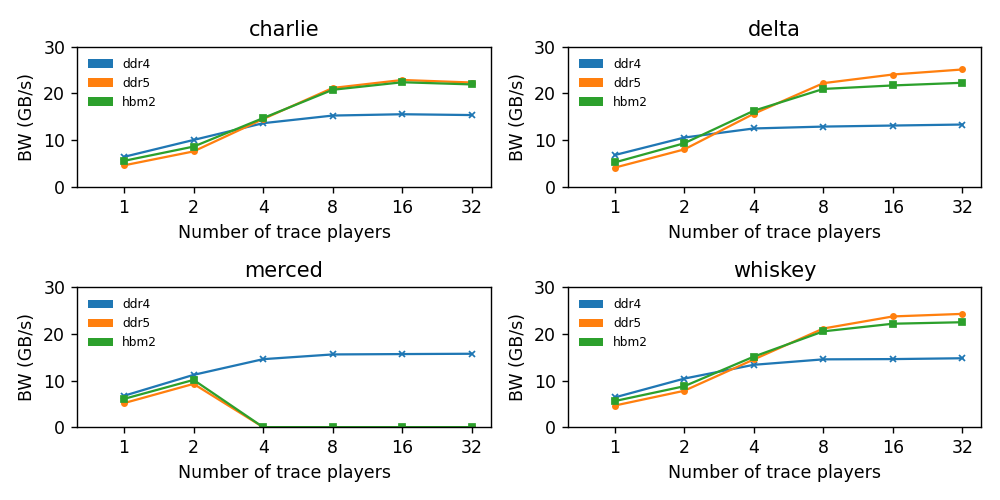

In [183]:
plot_conf('aggressive', 30)
savepdfviasvg(plt, "gtrace_aggressive_BW")

<IPython.core.display.Javascript object>


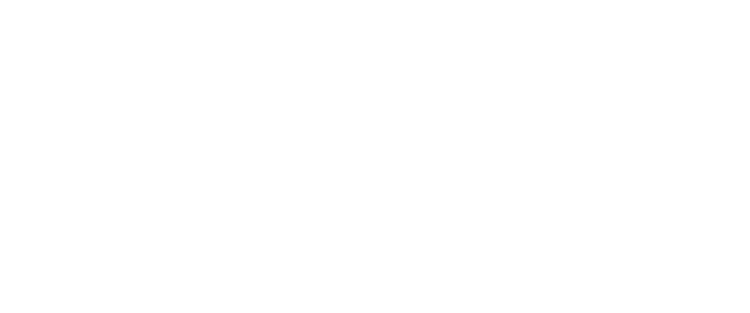

KeyError: 'totBW'

In [81]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('8p', '0', '0', '0', '', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 7}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s, 33GB/s, 32GB/s  -- 8 players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


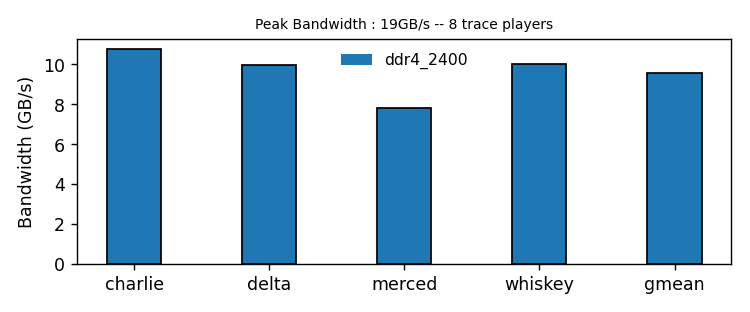

10755.8016
9963.4432
7832.774399999999
10029.3632


In [17]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat_ddr4('8p', '0', '0', '0', 'mesi2level-new', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
#plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 9}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s -- 8 trace players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
plt.savefig('gtrace_mesi_bw', format='png', dpi=1000)
savepdfviasvg(plt, "gtrace_mesi_bw")

<IPython.core.display.Javascript object>


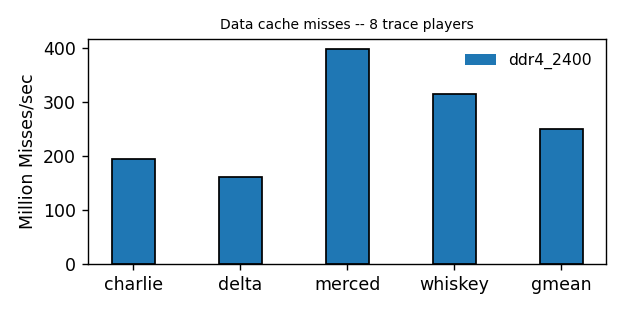

193.7958
160.5901
396.7929
314.5871


In [19]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 2.5

plt.figure()

doplot_stat_ddr4('8p', '0', '0', '0', 'mesi2level-new', 'l1dmissperSec')

plt.ylabel('Million Misses/sec')
#lt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 9}, frameon=0)
plt.title('Data cache misses -- 8 trace players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
plt.savefig('gtrace_mesi_dmiss', format='pdf', dpi=1000)
savepdfviasvg(plt, "gtrace_mesi_dmiss")

<IPython.core.display.Javascript object>


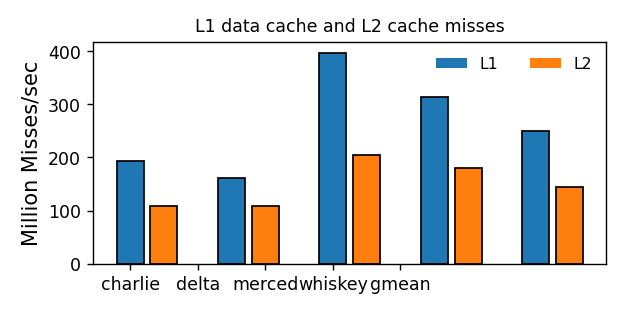

193.7958
193.7958
160.5901
160.5901
396.7929
396.7929
314.5871
314.5871


In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 2.5

plt.figure()

doplot_stat_ddr4_combined('8p', '0', '0', '0', 'mesi2level-new', 'l1dmissperSec', 'l2missperSec')

plt.ylabel('Million Misses/sec', fontsize=12)
#lt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 9}, frameon=0)
plt.title('L1 data cache and L2 cache misses', fontsize=10)
#plt.yscale("log")
plt.tight_layout()
plt.savefig('gtrace_mesi_combined_miss', format='pdf', dpi=1000)
savepdfviasvg(plt, "gtrace_mesi_combined_miss")

<IPython.core.display.Javascript object>


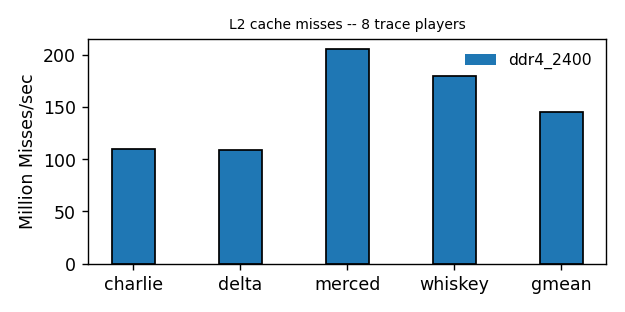

109.17360000000001
108.9803
204.9311
179.1849


In [20]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 5
fig_size[1] = 2.5

plt.figure()

doplot_stat_ddr4('8p', '0', '0', '0', 'mesi2level-new', 'l2missperSec')

plt.ylabel('Million Misses/sec')
#lt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 9}, frameon=0)
plt.title('L2 cache misses -- 8 trace players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
plt.savefig('gtrace_mesi_l2miss', format='pdf', dpi=1000)
savepdfviasvg(plt, "gtrace_mesi_l2miss")

<IPython.core.display.Javascript object>


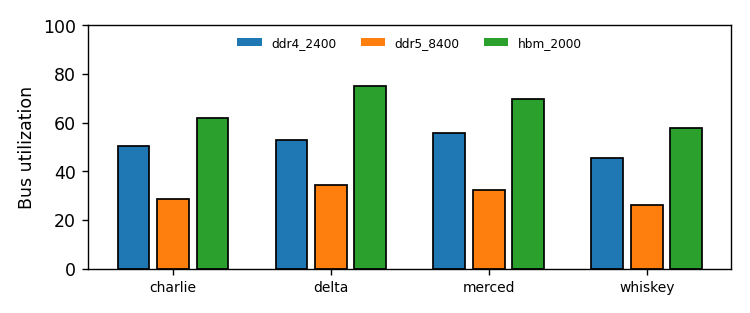

In [45]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('8p', '0', '0', '0', 'baseline', 'busUtil')

plt.ylabel('Bus utilization')
plt.ylim(ymax=100)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 7}, frameon=0)
#plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


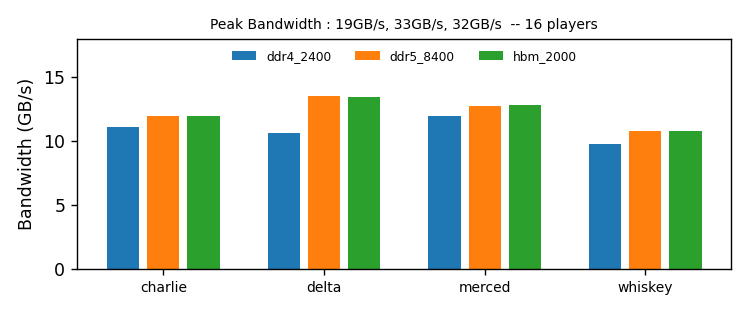

In [102]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('16p', '0', '0', '0', 'baseline', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 7}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s, 33GB/s, 32GB/s  -- 16 players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


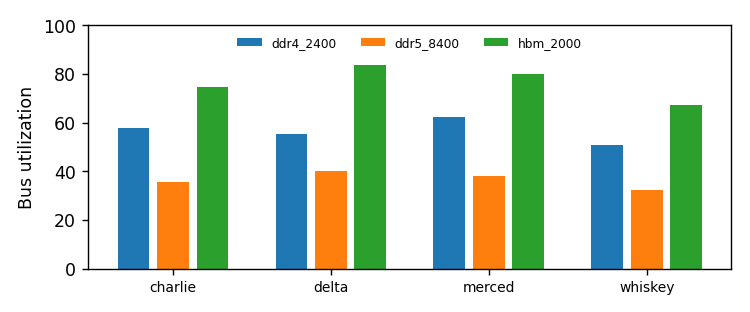

In [103]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('16p', '0', '0', '0', 'baseline', 'busUtil')

plt.ylabel('Bus utilization')
plt.ylim(ymax=100)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc='best', ncol=4, prop={'size': 7}, frameon=0)
#plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")